# Modal Tutorial 05 Part C: Selecting Excitation and Response Degrees of Freedom

We have discussed how to excite the structure and how to extract data from the structure.  However, how does one know *where* to excite the structure and *where* to measure the structure?

## Optimal Excitation Theory

In order to fit modes using experimental modal analysis, those modes must first be excited.  If there is no response of a given mode, then there is no way to fit an analytical model to that response.  So the idea is to excite the structure at locations that excite the modes of interest.

To find the locations that best excite the modes, we revisit the modal equations of motion from the previous tutorials.

$$\mathbf{Q} = \left(-\omega^2+i\omega\left[^\ddots2\zeta_n\omega_n{}_\ddots\right]+\left[^\ddots\omega_n^2{}_\ddots\right]\right)^{-1}\Phi^T\mathbf{F}$$

Here the modal response $\mathbf{Q}$ is determined by force $\mathbf{F}$ times the mode shape matrix transposed $\Phi^T$.  Note that it is also scaled by the dynamics of the part $\left(-\omega^2+i\omega\left[^\ddots2\zeta_n\omega_n{}_\ddots\right]+\left[^\ddots\omega_n^2{}_\ddots\right]\right)^{-1}$; however, we have no ability to modify this quantity as it is inherent to the structure of interest.

We previously called the quantity $$\tilde{\mathbf{f}} = \Phi^T \mathbf{f}$$ the *modal force* as it defines how much of the excitation gets transmitted to each mode of the structure.  We see that the mode shape matrix transposed $\Phi^T$ determines precisely how a physical force $\mathbf{f}$ turns into a modal force $\tilde{\mathbf{f}}$.  For example, if the location of a physical force were at a location where the modeshape has a coefficient of zero, then there would be no excitation of that mode by that force.  Rather if the physical force were at a location where the mode shape is large, then we would see that the mode would be excited very well by that force.

Let's look at an example of a 2D beam in SDynPy.

In [14]:
# Import modules we will use
import sdynpy as sdpy
import numpy as np
import matplotlib.pyplot as plt
# Create a beam
system,geometry = sdpy.System.beam(length=1.0,
                                   width=0.02,
                                   height=0.02,
                                   num_nodes=51,
                                   material='steel')
# Now let's reduce down to 2D.  Keep y-direction motion and rotation about z
coordinate_indices = np.where((system.coordinate.direction == 2) | (system.coordinate.direction == 6))[0]
system = sdpy.System(coordinate = system.coordinate[coordinate_indices],
                     mass = system.mass[coordinate_indices[:,np.newaxis],coordinate_indices],
                     stiffness = system.stiffness[coordinate_indices[:,np.newaxis],coordinate_indices],
                     damping = system.damping[coordinate_indices[:,np.newaxis],coordinate_indices],
                    )
# Add some damping for realism
system.assign_modal_damping(0.01)

Now let's look at the modes of the system.

In [16]:
modes = system.eigensolution(maximum_frequency=1000)

In [17]:
modes

   Index,  Frequency,    Damping,     # DoFs
    (0,),     0.0000,    0.0000%,        102
    (1,),     0.0076,    0.0864%,        102
    (2,),   103.7694,    1.0000%,        102
    (3,),   286.0446,    1.0000%,        102
    (4,),   560.7624,    1.0000%,        102
    (5,),   926.9713,    1.0000%,        102

Since our modal test will measure only on the elastic modes, we will focus on them.

In [18]:
modes = modes[2:]

In [19]:
modes

   Index,  Frequency,    Damping,     # DoFs
    (0,),   103.7694,    1.0000%,        102
    (1,),   286.0446,    1.0000%,        102
    (2,),   560.7624,    1.0000%,        102
    (3,),   926.9713,    1.0000%,        102

Let's look just at the translational degrees of freedom and discard the rotations.

In [31]:
response_dofs = np.unique(modes.coordinate[modes.coordinate.direction == 2])
shape_matrix = modes[response_dofs]

Let's look now at the shapes.

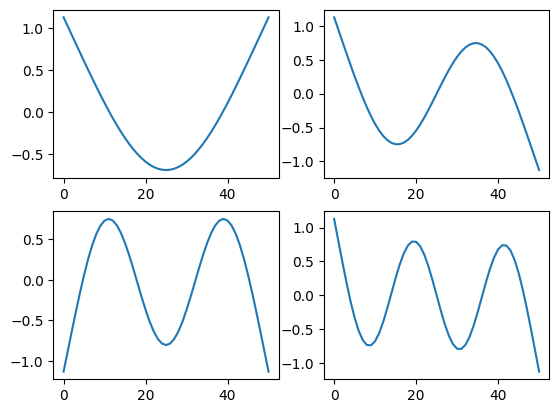

In [32]:
fig,ax = plt.subplots(2,2,num='Mode Shapes')
for shape,axis in zip(shape_matrix,ax.flatten()):
    axis.plot(shape)

Let's look at what happens if we put an excitation at the tip of the beam.

In [35]:
frf_tip = system.frequency_response(np.arange(1,1000,5),
                                   references=sdpy.coordinate_array(1,2),
                                   responses = response_dofs,
                                   displacement_derivative = 2)

array([<AxesSubplot: ylabel='Phase'>, <AxesSubplot: ylabel='Amplitude'>],
      dtype=object)

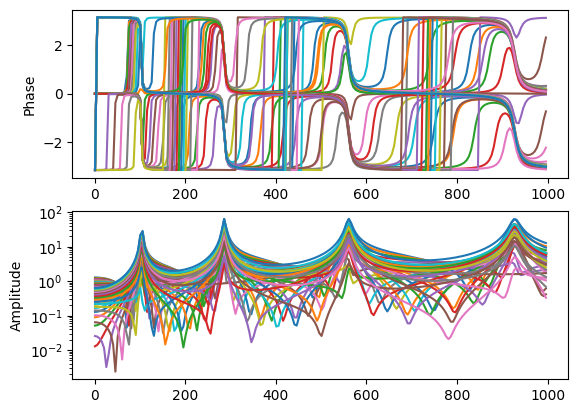

In [36]:
frf_tip.plot()

We can see we have 4 nice distinct peaks in the FRFs.  This would be considered a good excitation point, as it excites all the modes of interest.

Let's look now what happens if we excite at a location close to where the second mode has a zero in the mode shape.  For a symmetric mode, this should be just about in the middle of the beam.

In [41]:
min_dof_location = np.abs(shape_matrix[1]).argmin()+1
min_dof = sdpy.coordinate_array(min_dof_location,2)

array([<AxesSubplot: ylabel='Phase'>, <AxesSubplot: ylabel='Amplitude'>],
      dtype=object)

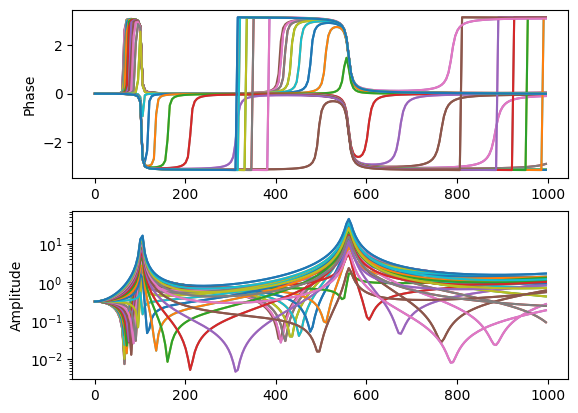

In [42]:
frf_middle = system.frequency_response(np.arange(1,1000,5),
                                   references=min_dof,
                                   responses = response_dofs,
                                   displacement_derivative = 2)
frf_middle.plot()

We can see we lost not only the second mode, but also the fourth mode.  This is because both of these modes are zero at the midpoint of the beam, so exciting at this location does not excite these two modes at all.

## Computing Optimal Excitation Locations

For a 2D beam, it is not too difficult to find an optimal drive location.  However, for more complex structures it can be challenging to find an optimal location intuitively.  Various algorithms have been proposed to select excitation locations based on the structures mode shapes.

A simple solution is simply to multiply the absolute value of the shape coefficients for all shapes in the frequency range of interest at each degree of freedom, and then select the degree of freedom with the largest product.  This is known as the *optimum drive point* algorithm.

$$ ODP_i = \prod_{j=1}^{n_{modes}} \left|\phi_{ij}\right| $$

This product will be large where all the shape coefficients are large.  The product will collapse to zero if any of the shapes have a zero coefficient.  Let's look at what this $ODP$ value looks like for our beam.

In [45]:
odp = np.prod(abs(shape_matrix),axis=0)

Text(0.5, 0, 'Excitation Location Along the Beam')

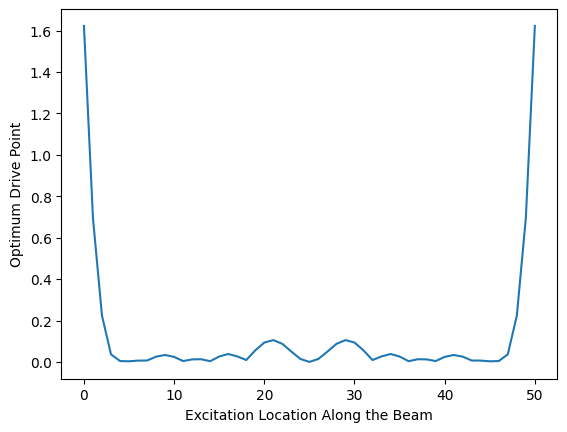

In [47]:
plt.plot(odp)
plt.ylabel('Optimum Drive Point')
plt.xlabel('Excitation Location Along the Beam')

We see that indeed the beam is best excited at its tips, as these are the location with the largest amplitude of motion while never having any nodal lines where a mode may be missed.

## Optimal Response Theory
Similarly to the excitation location, where the mode shape determines how strongly each mode is excited from a given physical excitation, the mode shape matrix also determines how a modal response translates into a physical response that can be measured.  The modal transformation is

$$ \mathbf{x} = \Phi\mathbf{q}$$

Obviously, if we can't measure the responses $\mathbf{x}$ corresponding to a given mode, we won't be able to fit that mode to the data.  We therefore want to place sensors where the response of the mode will be large so we are better able to measure it above the noise floor of our test.

Another consideration is the ability to distinguish modes from one another.  For example, if we just measured the beam tips and the midspan, the modes we would measure would look like

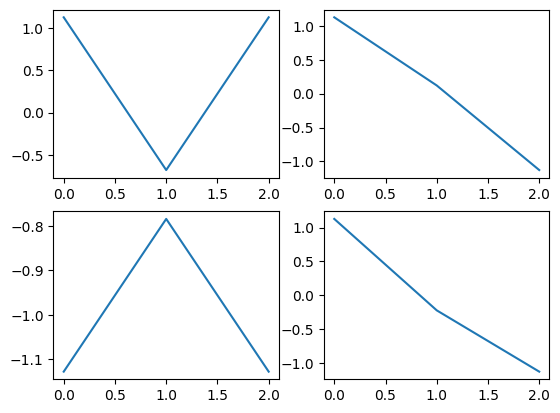

In [49]:
fig,ax = plt.subplots(2,2,num='Mode Shapes')
for shape,axis in zip(shape_matrix[:,[0,26,50]],ax.flatten()):
    axis.plot(shape)

Here modes 1 and 3 (left two plots) look the same (recall that mode shapes can be arbitrarily scaled by a scalar and still be valid).  Similarly, modes 2 and 4 (right plots) look basically the same.  With a poor instrumenation set, we have trouble distinguishing between modes and can lose physical insight into the structure's response.

Therefore an optimal response measurement set should contain both responses that are large in each mode shape, but also responses that produce linearly independent shapes.

## Computing Optimal Responses

A popular approach to computing optimal instrumentation utilizes a technique called Effective Independence, where a Fisher Information Matrix

$$ FIM = \Phi^T\Phi $$

We can use the determinant of this metric to define how good the sensor set is.  The determinant will be larger for larger coefficients of the mode shape matrix.  The determinant also considers linear independence of the sensor set because it will go to zero for linearly dependent mode shapes.

Many sensor optimizations work by discarding degrees of freedom one-by-one (or for triaxial sensors, three-by-three) from some initial sensor set.  The discarded degree(s) of freedom are the ones that contribute the minimum amount to the effective independence.

We can compute the effective independence of a sensor set using SDynPy.

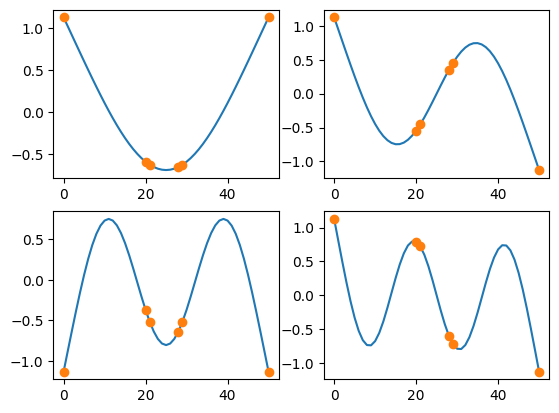

In [60]:
sensors_to_keep = 6
kept_indices = sdpy.dof.by_effective_independence(sensors_to_keep,shape_matrix.T)
fig,ax = plt.subplots(2,2)
for shape,axis in zip(shape_matrix,ax.flatten()):
    axis.plot(shape)
for shape,axis in zip(shape_matrix[:,kept_indices],ax.flatten()):
    axis.plot(kept_indices,shape,'o')

One drawback of effective independence is that once independence is achieved, it tends to cluster sensors at high-responding locations, as these are the locations that maximize the determinant.

A second approach is to maximize based on condition number of the mode shape matrix.  This directly focuses on the linear independence aspect of the problem with less emphasis on how large the responses are.

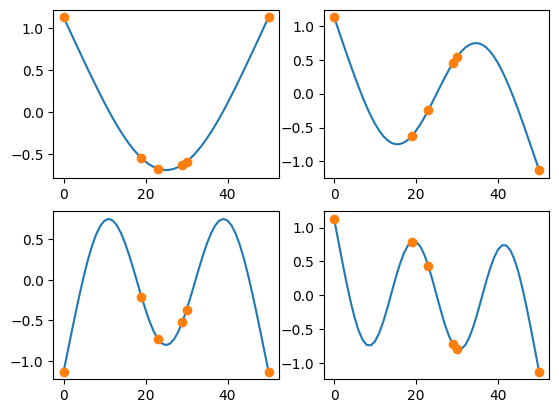

In [61]:
sensors_to_keep = 6
kept_indices = sdpy.dof.by_condition_number(sensors_to_keep,shape_matrix.T)
fig,ax = plt.subplots(2,2)
for shape,axis in zip(shape_matrix,ax.flatten()):
    axis.plot(shape)
for shape,axis in zip(shape_matrix[:,kept_indices],ax.flatten()):
    axis.plot(kept_indices,shape,'o')